In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from scipy.io import loadmat
from sklearn.decomposition import PCA

from lsc import LangevinSparseCoding
from utils import KLDivergence

# https://github.com/rctn/sparsecoding
from sparsecoding.visualization import plot_dictionary 
from sparsecoding.data.transforms.patch import sample_random_patches
from sparsecoding.data.utils import load_olshausen_dictionary


Text(0.5, 1.0, 'Learned dictionary (384 neurons)')

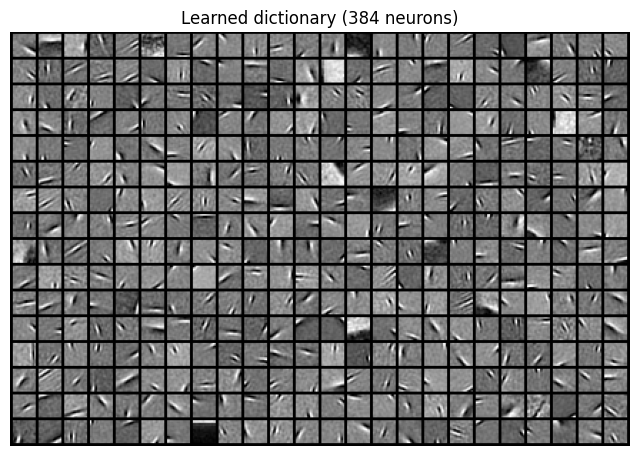

In [11]:
# load dictionary already learned on natural images
dictionary = load_olshausen_dictionary()
patch_size = int(np.sqrt(dictionary.shape[0]))
n_latent = dictionary.shape[1]

nrow = 24
fig,ax = plot_dictionary(dictionary,nrow=nrow,size=8)
ax.set_title('Learned dictionary (%d neurons)'%(n_latent))

torch.Size([10, 1, 512, 512])


(<Figure size 400x400 with 1 Axes>, <Axes: >)

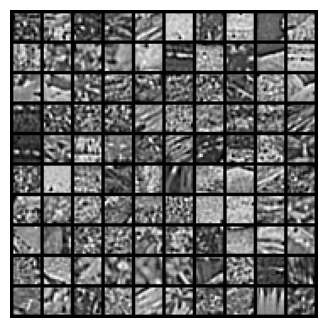

In [12]:
# download @ http://www.rctn.org/bruno/sparsenet/
img_dir = '/Users/belsten/Documents/datasets/IMAGES.mat'

images = loadmat(img_dir)['IMAGES']
images = torch.tensor(images).permute([2,0,1]).unsqueeze(1)
images = images.type(torch.float32)
print(images.shape)

n_images = images.shape[-1]
n_patches = int(1e2)
patch_size = 16
patches = sample_random_patches(image=images, patch_size=patch_size,num_patches=n_patches)
data = patches.reshape([n_patches, -1])
plot_dictionary(data[0:100,:].T,nrow=10,size=4)

In [34]:
def compute_map(x,lsc:LangevinSparseCoding,n_iterations:int,return_all:bool=False):
    batch_size = x.shape[0]
    s_map = torch.zeros([batch_size,lsc.n_latent])

    all_s_map = torch.empty([batch_size,n_iterations+1,lsc.n_latent])
    all_s_map[:,0,:] = torch.clone(s_map)

    for n in (range(n_iterations)):
        # warm start at map estimate
        ds = lsc.dt*lsc.energy_grad(x,s_map)
        s_map -= torch.clone(ds)
        all_s_map[:,n+1,:] = torch.clone(s_map)
    return all_s_map

In [68]:
n_features = patch_size**2
sparsity_penalty = 1.
temperature = 1
dt = 5e-3
mass = 1
NOISE_MEAN, NOISE_STD = 0 , 0.1

C = lambda s: s.abs().sum(dim=1)
Cprime = lambda s: torch.sign(s)

lsc = LangevinSparseCoding(
    n_features=n_features,
    n_latent=n_latent,
    sparsity_penaly=sparsity_penalty,
    temperature=temperature,
    dt=dt,
    cost_function=C,
    cost_function_grad=Cprime,
    mass=mass,
    gauss_std=NOISE_STD
)

lsc.A = torch.FloatTensor(dictionary)

In [77]:
n_warm_start = int(4e2)
tmax = int(1e4)

Smap = compute_map(data,lsc,n_warm_start)

S = torch.empty([data.shape[0],tmax,n_latent])
s = torch.clone(Smap[:,-1,:])
v = torch.zeros_like(s) #Change to L0
for n in tqdm(range(tmax)):
    
    ds,dv = lsc.second_order_langevin_update(data,s,v)
    s += torch.clone(ds)
    v += torch.clone(dv)
    S[:,n,:] = torch.clone(s)    

100%|██████████| 10000/10000 [00:08<00:00, 1137.48it/s]


In [37]:
Smap.shape

torch.Size([100, 101, 384])

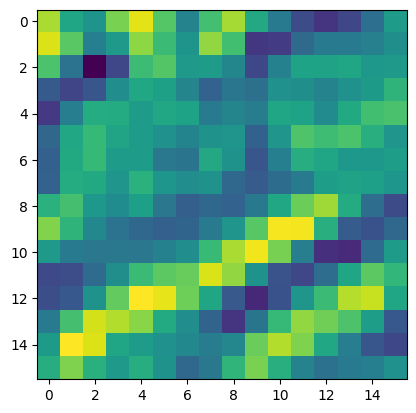

In [24]:
img_idx = 4
plt.imshow(data[img_idx,:].reshape([patch_size,patch_size]))

MovieWriter ffmpeg unavailable; using Pillow instead.


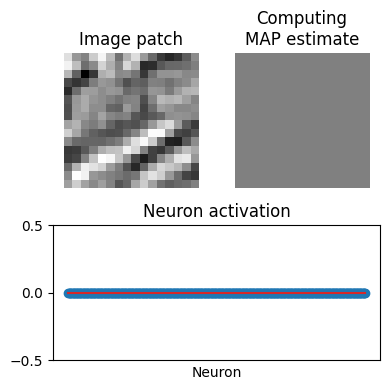

In [62]:
from matplotlib.animation import FuncAnimation 

img_idx = 4
vmin = data[img_idx,:].min()
vmax = data[img_idx,:].max()

fig = plt.figure(figsize=(4, 4))
fig.set_tight_layout(True)
# plt.subplots_adjust(bottom = 0., left = 0, top = 1., right = 1)

# Create first axes, the top-left plot with green plot
sub1 = fig.add_subplot(2,2,1) # two rows, two columns, fist cell
ax = sub1
ax.imshow(data[img_idx,:].reshape([patch_size,patch_size]),'gray',vmin=vmin,vmax=vmax)
ax.set_aspect('equal')
ax.set_title(r'Image patch')
ax.set_axis_off()


# Create second axes, the top-right plot with orange plot
sub2 = fig.add_subplot(2,2,2) # two rows, two columns, second cell


# Create third axes, a combination of third and fourth cell
sub3 = fig.add_subplot(2,2,(3,4)) # two rows, two colums, combined third and fourth cell


def animate(idx):
    ax = sub2
    ax.clear()

    if idx < Smap.shape[1]:
        curr_s = Smap[img_idx,idx,:].numpy()
        title = 'Computing\nMAP estimate'
    else:
        curr_s = S[img_idx,idx-Smap.shape[1],:]
        title = 'Sampling\n$P(s|x)$'
    xhat = dictionary@curr_s
    ax.imshow(xhat.reshape([patch_size,patch_size]),'gray',vmin=vmin,vmax=vmax)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_axis_off()

    ax = sub3
    ax.clear()
    ax.stem(curr_s)
    ax.set_title('Neuron activation')
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([-0.5,0,0.5])
    ax.set_xlabel('Neuron')


n_frames = Smap.shape[1]+tmax
movie_len_s = 15
fps = n_frames/movie_len_s
interval_ms = 1/fps*1e3

anim = FuncAnimation(fig, animate, frames = n_frames,interval=interval_ms)
   
anim.save(
    'movies/natural_image_reconstruction.gif', 
    writer = 'ffmpeg', 
    fps = n_frames/movie_len_s,
    # savefig_kwargs={'bbox_inches' : 'tight'}
)

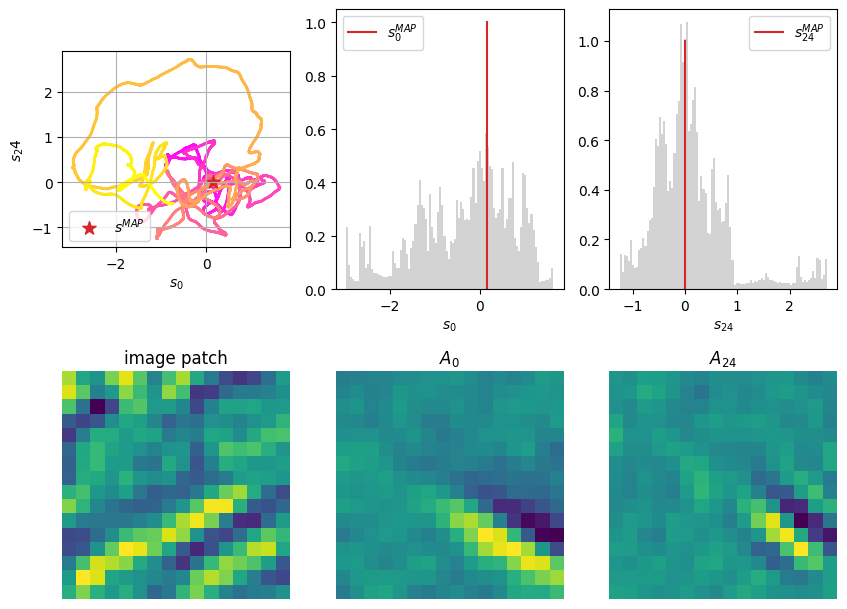

In [78]:
s_id1,s_id2 = 0,24


fig, axes = plt.subplots(2,3, figsize=(10, 8))
axes = axes.flatten()
colors = cm.spring(np.linspace(0, 1, S.shape[1]))
axes[0].scatter(*S[img_idx,:,(s_id1,s_id2)].T, color=colors, s=1)
# axes[0].plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# axes[0].plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
axes[0].set_aspect('equal')
axes[0].set_xlabel(r'$s_%d$'%(s_id1))
axes[0].set_ylabel(r'$s_%d$'%(s_id2))
axes[0].grid()
axes[0].scatter(Smap[img_idx,-1,s_id1],Smap[img_idx,-1,s_id2],marker='*',s=100,label=r'$s^{MAP}$',c='C3')
# axes[0].scatter(Sbar[s_id1],   Sbar[s_id2],marker='*',s=100,label=r'$\bar{s}$',c='C4')
# np.expand_dims(Smap[-1,(s_id1,s_id1)],0).T
axes[0].legend()

axes[1].hist(S[img_idx,:, s_id1], fc='lightgrey', bins=100, density=True)
# axes[1].plot(s_, p_, 'r--')
axes[1].set_xlabel(r'$s_{%d}$'%(s_id1))
axes[1].plot([Smap[img_idx,-1,s_id1],Smap[img_idx,-1,s_id1]],[0,1],color='C3',label=r'$s^{MAP}_{%d}$'%(s_id1))
# axes[1].plot([Sbar[s_id1],Sbar[s_id1]],[0,1],color='C4',label=r'$\bar{s}_%d$'%(s_id1))
axes[1].legend()

axes[2].hist(S[img_idx,:, s_id2], fc='lightgrey', bins=100, density=True)
# axes[2].plot(s_, p_, 'g--')
axes[2].set_xlabel(r'$s_{%d}$'%(s_id2))
# plt.suptitle(rf'$dt = {dt:.2f} M^{{-1}}$ ; $T = {TAU_SCALE} \mu^{{-1}}$')
# plt.savefig(f'{TAU_SCALE}_{DT_SCALE}.pdf')
axes[2].plot([Smap[img_idx,-1,s_id2],Smap[img_idx,-1,s_id2]],[0,1],color='C3',label=r'$s^{MAP}_{%d}$'%(s_id2))
# axes[2].plot([Sbar[s_id2],Sbar[s_id2]],[0,1],color='C4',label=r'$\bar{s}_%d$'%(s_id2))
axes[2].legend()

# plot the energy function on a smaller scale 
ax = axes[3]
ax.imshow(data[img_idx,:].reshape([patch_size,patch_size]))
ax.set_aspect('equal')
ax.set_title(r'image patch')
ax.set_axis_off()

ax = axes[4]
ax.imshow(dictionary[:,s_id1].reshape([patch_size,patch_size]))
ax.set_aspect('equal')
ax.set_title(r'$A_{%d}$'%(s_id1))
ax.set_axis_off()

ax = axes[5]
ax.imshow(dictionary[:,s_id2].reshape([patch_size,patch_size]))
ax.set_aspect('equal')
ax.set_title(r'$A_{%d}$'%(s_id2))
ax.set_axis_off()


### Project onto PCs

In [138]:
pca = PCA(n_components=n_latent)
S_pcs = pca.fit_transform(S)
Sbar_pcs = np.mean(S_pcs,axis=0)

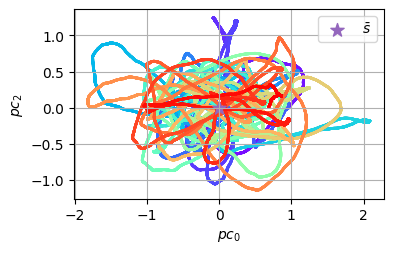

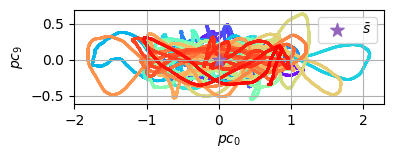

In [141]:
pc_v1,pc_v2 = 0,2

fig, ax = plt.subplots(1,1, figsize=(4, 4))
colors = cm.rainbow(np.linspace(0, 1, S.shape[0]))
ax.scatter(*S_pcs[:,(pc_v1,pc_v2)].T, color=colors, s=1)
ax.set_aspect('equal')
ax.set_xlabel(r'$pc_%d$'%(pc_v1))
ax.set_ylabel(r'$pc_%d$'%(pc_v2))
ax.scatter(Sbar_pcs[pc_v1],   Sbar_pcs[pc_v2],marker='*',s=100,label=r'$\bar{s}$',c='C4')
ax.legend()
ax.grid()

pc_v1,pc_v2 = 0,9

fig, ax = plt.subplots(1,1, figsize=(4, 4))
colors = cm.rainbow(np.linspace(0, 1, S.shape[0]))
ax.scatter(*S_pcs[:,(pc_v1,pc_v2)].T, color=colors, s=1)
ax.scatter(Sbar_pcs[pc_v1],   Sbar_pcs[pc_v2],marker='*',s=100,label=r'$\bar{s}$',c='C4')
ax.set_aspect('equal')
ax.set_xlabel(r'$pc_%d$'%(pc_v1))
ax.set_ylabel(r'$pc_%d$'%(pc_v2))
ax.legend()
ax.grid()